### Handle the data

In [2]:
import torch
from torch.utils.data import Dataset


class LSTMStocksDataset(Dataset):
    def __init__(self, x_tensor: torch.Tensor, y_tensor: torch.Tensor):
        self._x_tensor = x_tensor
        self._y_tensor = y_tensor

    def __len__(self):
        return self._y_tensor.shape[0]

    def __getitem__(self, idx: int):
        return self._x_tensor[idx, :], self._y_tensor[idx]

### Construct the LSTM network

In [3]:
from torch import nn


class LSTMStocksModule(nn.Module):
    HIDDEN_SIZE = 2  # Number of LSTM hidden nodes
    NUM_LAYERS = 1  # Number of LSTM layers
    BIAS = True  # Whether to include the bias term for some of LSTM's equations

    def __init__(self):
        super(LSTMStocksModule, self).__init__()
        self.lstm = nn.LSTM(
            1,
            self.HIDDEN_SIZE,
            self.NUM_LAYERS,
            self.BIAS,
            batch_first=True
        )
        if self.HIDDEN_SIZE > 1:
            self.linear = nn.Linear(self.HIDDEN_SIZE, 1, bias=False)

    def forward(self, x):
        _, (hidden, cell) = self.lstm(x.unsqueeze(-1))
        out = hidden.squeeze()
        if self.HIDDEN_SIZE > 1:
            out = self.linear(out).squeeze()
        return out

### Helper functions

In [4]:
from functools import partial

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from scipy.stats import norm


LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-6

In [5]:
def _draw_chart(y_series: pd.Series):
    y_series.plot.hist(bins=50, label='Target Returns')

    # Draw Gaussian curve
    mu, stdev = norm.fit(y_series)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 50)
    p = norm.pdf(x, mu, stdev)
    p *= y_series.shape[0] / p.sum()

    plt.plot(x, p, 'k', linewidth=2, label='Gaussian Curve')
    plt.legend()

In [6]:
def chart_y_histogram(y_series: pd.Series):
    """
    Create charts that contain the histogram of the inputs and compares them against Normal distributions.
    :param y_series: Data to create charts for.
    """
    _draw_chart(y_series)
    plt.show()

    _draw_chart(y_series)
    xmin, _ = plt.xlim()
    plt.axis([xmin, -0.015, 0, 10])
    plt.show()

In [7]:
def predict(trained_model, x_df: pd.DataFrame) -> pd.Series:
    """
    Generates predictions using a trained model
    :param trained_model: Trained Pytorch model
    :param x_df: Inputs to generate predictions for
    :return: Series containing predictions, with reference dates as indices
    """
    # Convert pandas DataFrame to torch Tensor and move to model's device
    device = next(trained_model.parameters()).device
    x_tensor = torch.tensor(x_df.values, dtype=torch.float32).to(device)

    trained_model.eval()

    prediction = trained_model(x_tensor)

    return pd.Series(prediction.cpu().detach().numpy(), index=x_df.index)

In [8]:
def train(x_df: pd.DataFrame, y_series: pd.Series, epochs: int = 100):
    """
    Trains the LSTMStocksModule model
    :param x_df: Inputs consisting of sequences of stock price returns
    :param y_series: Targets consisting of returns some days in advance of the reference dates
    :param epochs: Number of complete iterations to go through the data in order to train
    :return: The trained LSTMStocksModule model
    """

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Convert pandas objects to Pytorch tensor objects and move to the correct device
    x_tensor = torch.tensor(x_df.values, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_series.values, dtype=torch.float32).to(device)

    # Set up the dataloader
    train_dataset = LSTMStocksDataset(x_tensor, y_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Initialize model and move to device
    model = LSTMStocksModule().to(device).train()

    loss_func = partial(torch.nn.functional.huber_loss, delta=0.02)
    chart_y_histogram(y_series)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

    # Conduct training which consists of homing the model in on the best parameters that minimize the loss
    for epoch in range(epochs):
        total_loss = 0.
        for x, y in train_dataloader:
            optimizer.zero_grad()
            out = model(x)
            loss = loss_func(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().detach().numpy()

        print(f"[Epoch {epoch}] Loss: {total_loss:.4f}")

    return model

### Preprocess the data

In [9]:
import pandas as pd

def process_inputs(perf_series: pd.Series, window_length: int) -> pd.DataFrame:
    """
    Creates sequences consisting of data from across a moving window. For example, given a window length of 10,
    sequences will span indices 0-9, 1-10, 2-11, etc.
    :param perf_series: The stock price returns data to extract sequences from.
    :param window_length: The size of the moving window.
    :return: Pandas DataFrame where each row contains a sequence, and the index refers to the most recent input date,
    a.k.a. the reference date.
    """
    dataframes = []
    for i in range(window_length):
        dataframes.append(perf_series.shift(i).to_frame(f"T - {i}"))

    return pd.concat(reversed(dataframes), axis=1).dropna()

In [10]:
def process_targets(perf_series: pd.Series) -> pd.Series:
    """
    Creates targets consisting of data 2 days after the reference date (i.e. the most recent input's date)
    :param perf_series: The stock price returns data to extract targets from.
    :return: A series where the values consist of returns 2 days after the reference dates, and where the index consists
    of the reference dates.
    """
    return perf_series.shift(-2).dropna()

### Fit the training data to the model

In [11]:
import datetime

import pytz as pytz
import yfinance as yf
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

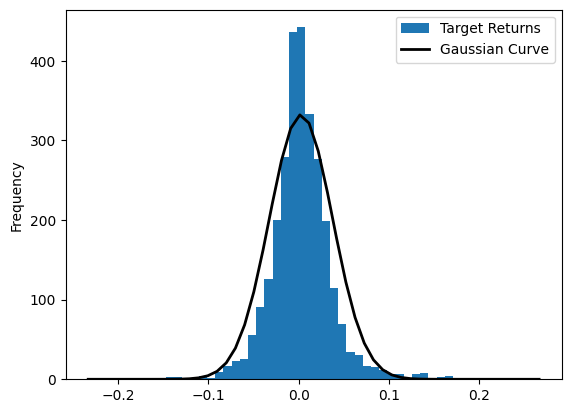

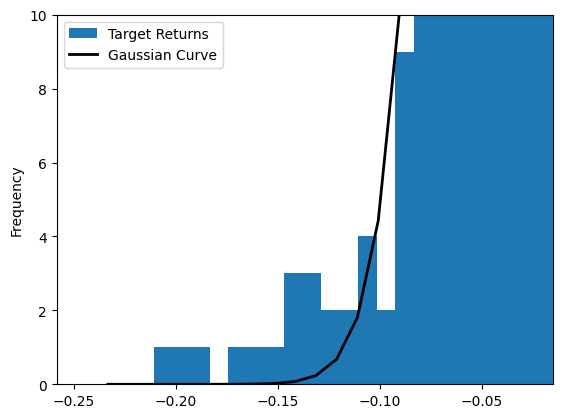

[Epoch 0] Loss: 0.1507
[Epoch 1] Loss: 0.1448
[Epoch 2] Loss: 0.1390
[Epoch 3] Loss: 0.1335
[Epoch 4] Loss: 0.1282
[Epoch 5] Loss: 0.1232
[Epoch 6] Loss: 0.1182
[Epoch 7] Loss: 0.1135
[Epoch 8] Loss: 0.1090
[Epoch 9] Loss: 0.1047
[Epoch 10] Loss: 0.1005
[Epoch 11] Loss: 0.0965
[Epoch 12] Loss: 0.0925
[Epoch 13] Loss: 0.0888
[Epoch 14] Loss: 0.0852
[Epoch 15] Loss: 0.0817
[Epoch 16] Loss: 0.0783
[Epoch 17] Loss: 0.0751
[Epoch 18] Loss: 0.0719
[Epoch 19] Loss: 0.0689
[Epoch 20] Loss: 0.0660
[Epoch 21] Loss: 0.0633
[Epoch 22] Loss: 0.0605
[Epoch 23] Loss: 0.0580
[Epoch 24] Loss: 0.0555
[Epoch 25] Loss: 0.0531
[Epoch 26] Loss: 0.0508
[Epoch 27] Loss: 0.0486
[Epoch 28] Loss: 0.0465
[Epoch 29] Loss: 0.0444
[Epoch 30] Loss: 0.0425
[Epoch 31] Loss: 0.0406
[Epoch 32] Loss: 0.0389
[Epoch 33] Loss: 0.0372
[Epoch 34] Loss: 0.0356
[Epoch 35] Loss: 0.0341
[Epoch 36] Loss: 0.0327
[Epoch 37] Loss: 0.0313
[Epoch 38] Loss: 0.0300
[Epoch 39] Loss: 0.0288
[Epoch 40] Loss: 0.0277
[Epoch 41] Loss: 0.0266
[E

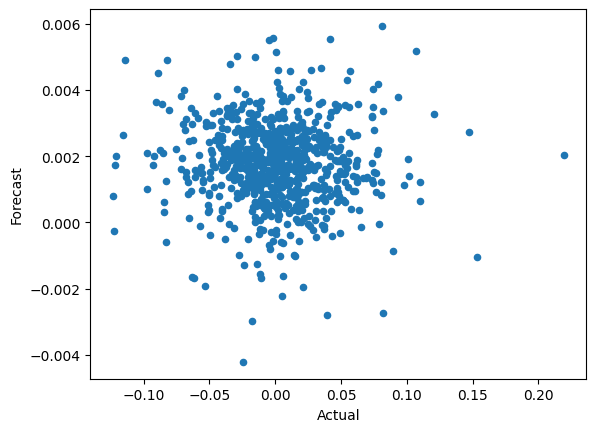

R Squared: -0.0031, Mean Absolute Error: 0.0286


In [18]:
# Download price histories from Yahoo Finance
tsla = yf.Ticker('TSLA')
price_series = tsla.history(period='max')['Close'].dropna()

perf_series = price_series.pct_change().dropna()

x_df = process_inputs(perf_series, window_length=30)
y_series = process_targets(perf_series)

# Only keep rows in which we have both inputs and data.
common_index = x_df.index.intersection(y_series.index)
x_df, y_series = x_df.loc[common_index], y_series.loc[common_index]

# Isolate training data
# Train the stock data before 2022/1/1
training_cutoff = datetime.datetime(2022, 1, 1, tzinfo=pytz.timezone('America/New_York'))
training_x_series = x_df.loc[x_df.index < training_cutoff]
training_y_series = y_series.loc[y_series.index < training_cutoff]

trained_model = train(training_x_series, training_y_series)

# Isolate test data
test_x_series = x_df.loc[x_df.index >= training_cutoff]
actual_series = y_series.loc[y_series.index >= training_cutoff]

forecast_series = predict(trained_model, test_x_series)
results_df = forecast_series.to_frame('Forecast').join(actual_series.to_frame('Actual')).dropna()

# Evaluate forecasts
results_df.plot.scatter(x='Actual', y='Forecast')
plt.show()
print(f"R Squared: {r2_score(results_df['Actual'], results_df['Forecast']):.4f}, "
        f"Mean Absolute Error: {mean_absolute_error(results_df['Actual'], results_df['Forecast']):.4f}")

In [16]:
x_df.to_csv('x_df.csv')

In [17]:
y_series.to_csv('y_series.csv')